In [1]:
import jammy_flows
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.optim import Adam 
import math
import pandas as pd
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
import jammy_flows.helper_fns as helper_fns
import corner

/home/chrhck/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_hook(fn):
    def hook(i, o):
        print(fn, i, o)
    fn.register_hook(hook)


a = torch.tensor([2.], requires_grad=True)
b = torch.tensor([3.], requires_grad=True)

c = a**2 * torch.exp(b)
make_hook(c.grad_fn.next_functions[0][0])
make_hook(c.grad_fn.next_functions[1][0])
make_hook(c.grad_fn)

c.backward()

print(a.grad)
print(b.grad)







<MulBackward0 object at 0x7fca4c307f40> (tensor([20.0855]), tensor([4.])) (tensor([1.]),)
<ExpBackward0 object at 0x7fca4c307fa0> (tensor([80.3421]),) (tensor([4.]),)
<PowBackward0 object at 0x7fca4c469210> (tensor([80.3421]),) (tensor([20.0855]),)
tensor([80.3421])
tensor([80.3421])


In [3]:
def cart_to_sph(x, y, z):
    out = np.empty((x.shape[0], 2))

    out[:, 0] = np.arccos(z)

    atan = np.arctan2(y, x)

    mask = (x != 0) & (y != 0)
    out[mask, 1] = atan[mask]

    mask = (x==0) & (y!=0)
    out[mask, 1] = np.pi/2 * np.sign(y[mask])

    mask = (x==0) & (y==0)
    out[mask, 1] = 0

    mask = out[:, 1] < 0
    out[mask, 1] = out[mask, 1] + 2*np.pi

    return out

def sph_to_cart(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z

def seed_everything(seed_no):
    random.seed(seed_no)
    np.random.seed(seed_no)
    torch.manual_seed(seed_no)




In [4]:
class HDF5PMTTable(Dataset):
    def __init__(self, filename, start, end=-1):
        super(HDF5PMTTable).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        self.data = []
        self.weights = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]

            data_df = pd.DataFrame(data.T, columns=["time", "pmt_id", "weight"])
            data_df = data_df.loc[data_df["weight"] > 0]


            if len(data_df) > 1000:
                data_df = data_df.sample(1000)


            data_df["weight"] = data_df.groupby("pmt_id")["weight"].transform(lambda x: x / x.sum())
            data = data_df.to_numpy()

            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[:, 1] - 1), 16)

            labels = torch.empty((data.shape[0], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]

            #time_res = torch.DoubleTensor(data[:, 0]) - labels[:, 0] / (0.25)
            labels[:, len(label_order):] = pmt_encoding
            
            labels[:, 0] = np.log10(labels[:, 0])
            labels[:, 1] = np.log10(labels[:, 1])

            self.data.append(torch.DoubleTensor(data[:, 0]))
            self.weights.append(torch.DoubleTensor(data[:, 2]))
            self.labels.append(labels)
        
        self.data = torch.concat(self.data)
        self.weights = torch.concat(self.weights)
        self.labels = torch.concat(self.labels)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.weights[key], self.labels[key]


class HDF5PMTTableUnWeighted(Dataset):
    def __init__(self, filename, start, end=-1):
        super(HDF5PMTTableUnWeighted).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        self.data = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]

            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[0] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]

            #time_res = torch.DoubleTensor(data[:, 0]) - labels[:, 0] / (0.25)
            labels[:, len(label_order):] = pmt_encoding
            
            labels[:, 0] = np.log10(labels[:, 0])
            labels[:, 1] = np.log10(labels[:, 1])

            self.data.append(torch.DoubleTensor(data[0]))
            self.labels.append(labels)
        
        self.data = torch.concat(self.data)
        self.labels = torch.concat(self.labels)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.labels[key]

    """
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        for i in range(iter_start, iter_end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]
            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[1] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]
            
            labels[:, len(label_order):] = pmt_encoding

            yield torch.DoubleTensor(data[0]).to(device), torch.DoubleTensor(data[2]).to(device), labels.to(device)
    """




class HDF5PPhotonTable(Dataset):
    def __init__(self, filename, start, end=-1, time_range=(-np.inf, np.inf)):
        super(HDF5PPhotonTable).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photons"].keys())
        label_order = ["distance", "energy", "dir_costheta", "dir_phi"]
       
        self.data = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = torch.DoubleTensor(self._hdl["photons"][grp][:])

            labels_d = dict(self._hdl["photons"][grp].attrs)
            cart_dir = sph_to_cart(np.arccos(labels_d["dir_costheta"]), labels_d["dir_phi"])
            labels = torch.empty((data.shape[1], 5), dtype=torch.float64)
            labels[:, 0] = np.log10(np.float64(labels_d["distance"]))
            labels[:, 1] = np.log10(np.float64(labels_d["energy"]))
            labels[:, 2] = cart_dir[0]
            labels[:, 3] = cart_dir[1]
            labels[:, 4] = cart_dir[2]

            #print(np.min(data[0]))
            #print(np.max(data[0]))

            time_mask = (data[0] > time_range[0]) & (data[0] < time_range[1])

            data = data[:,time_mask]
            data = data[:, :10000]
            

            data_t = torch.empty((data.shape[1], 4), dtype=torch.float64)
            data_t[:, 0] = data[0]
           
            xyz = data[1:4] / np.linalg.norm(data[1:4], axis=0)

            sph = torch.DoubleTensor(cart_to_sph(xyz[0], xyz[1], xyz[2]))
            data_t[:, 1:3] = sph
            data_t[:, 3] = data[-1] / (torch.sum(data[-1]) * data.shape[0])

            self.data.append(data_t)
            self.labels.append(labels)
        
        self.data = torch.vstack(self.data)
        self.labels = torch.concat(self.labels)

        self.scales = torch.std(self.labels, axis=0)        
        self.means = torch.mean(self.labels, axis=0)

        self.labels = (self.labels - self.means[np.newaxis, :]) / self.scales[np.newaxis, :]
        


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.labels[key]


In [5]:
def read_pmt_table_hdf(fname, ix):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photon_tables"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["time", "pmt_id", "weight"])
        data_df = data_df.loc[data_df["weight"] > 0]

        data_df["weight"] = data_df.groupby("pmt_id")["weight"].transform(lambda x: x / x.sum())

        
        labels_d = dict(hdl["photon_tables"][grp].attrs)
        
    return data_df, labels_d

def read_pmt_table_hdf_unweighted(fname, ix):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photon_tables"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["pmt_id", "tres"])
        labels_d = dict(hdl["photon_tables"][grp].attrs)
        
    return data_df, labels_d

def read_photon_table_hdf_unweighted(fname, ix, ds):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photons"].keys())

        label_order = ["distance", "energy", "dir_costheta", "dir_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photons"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["tres", "pos_x", "pos_y", "pos_z", "weight"])
        

        labels_d = dict(hdl["photons"][grp].attrs)
        cart_dir = sph_to_cart(np.arccos(labels_d["dir_costheta"]), labels_d["dir_phi"])
        labels = torch.empty((data.shape[1], 5), dtype=torch.float64)
        labels[:, 0] = np.log10(np.float64(labels_d["distance"]))
        labels[:, 1] = np.log10(np.float64(labels_d["energy"]))
        labels[:, 2] = cart_dir[0]
        labels[:, 3] = cart_dir[1]
        labels[:, 4] = cart_dir[2]

        labels = (labels - ds.means[np.newaxis, :]) / ds.scales[np.newaxis, :]
        
    return data_df, labels


        

In [6]:
seed_everything(31337)
ds = HDF5PPhotonTable("../assets/photon_tables_extended_1.hd5", 0, 400) #time_range=(-50, 200))

split_len = int(np.ceil(0.9*len(ds)))

train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=2000, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=5000)
extra_flow_defs = {
    "g": {
        "softplus_for_width": 1,
        "upper_bound_for_widths": 100,
        "lower_bound_for_widths": 0.1,
        #"nonlinear_stretch_type": "rq_splines"
    }
}


pdf = jammy_flows.pdf("e1+s2", "gg+vvvvv", conditional_input_dim=5, hidden_mlp_dims_sub_pdfs="256", options_overwrite=extra_flow_defs)
pdf.init_params(data=next(iter(train_loader))[0][:, :3])

optim = Adam(pdf.parameters(), lr=0.001)
writer = SummaryWriter("/tmp/tensorboard/nflow_e1s2")

data_df, labels_plot = read_photon_table_hdf_unweighted("../assets/photon_tables_extended_1.hd5", 401, ds)

train_iter = 0
for epoch in range(100):
    loss = 0
    pdf = pdf.to(device)
    for (data, labels) in train_loader:
        train_iter += 1
        optim.zero_grad()

        data = data.to(device)
        inp = data[:, :3]
        w = data[:, 3] *data.shape[0]/ sum(data[:, 3])
        labels = labels.to(device)

        if torch.any(~torch.isfinite(inp)) or (torch.any(~torch.isfinite(w))) or (torch.any(~torch.isfinite(labels))):
            raise RuntimeError("NaN in input")

        transformed_input = pdf.transform_target_into_returnable_params(inp)

        log_pdf, _, _ = pdf(transformed_input, conditional_input=labels, force_embedding_coordinates=True) 
        neg_log_loss = (-log_pdf * w).mean()
        neg_log_loss.backward()

        #torch.nn.utils.clip_grad_norm(pdf.parameters(), clip_value=0.3)
        
        total_norm = 0
        for p in pdf.parameters():
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5

        grad_max = max([p.grad.detach().data.max() for p in pdf.parameters()])
        grad_min = min([p.grad.detach().data.min() for p in pdf.parameters()])

        for p in pdf.parameters():
            if torch.any(~torch.isfinite(p.grad)):
                torch.save({
                'model_state_dict': pdf.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'batch': (data, labels) 
                }, f"../assets/models/checkpoint_{epoch}_nangrad.pt")
                raise RuntimeError()
           
        optim.step()
        loss += neg_log_loss.detach()

        writer.add_scalar('Loss/train_batch', neg_log_loss.detach(), train_iter)
        writer.add_scalar('Gradient/norm', total_norm, train_iter)
        writer.add_scalar('Gradient/max', grad_max, train_iter)
        writer.add_scalar('Gradient/min', grad_min, train_iter)
       
    loss /= len(train_loader)
 
    loss_test = 0
    for (data, labels) in test_loader:
        data = data.to(device)
        inp = data[:, :3]
        w = data[:, 3] *data.shape[0]/ sum(data[:, 3])
        labels = labels.to(device)

        transformed_input = pdf.transform_target_into_returnable_params(inp)
        log_pdf, _, _ = pdf(transformed_input, conditional_input=labels, force_embedding_coordinates=True) 
        loss_test += (-log_pdf * w).mean().detach()
    
    loss_test /= len(test_loader)

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/test', loss_test, epoch)

    fig = plt.figure(figsize=(8,6))
    helper_fns.visualize_pdf(
        pdf.to("cpu"),
        fig,
        nsamples=10000,
        conditional_input=labels_plot,
        bounds=[[-50, 150], [0, np.pi], [0, 2*np.pi]],
        #s2_norm="lambert"
        );
    writer.add_figure("Flow", fig, epoch)
    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")

    torch.save({
            'epoch': epoch,
            'model_state_dict': pdf.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
            }, f"../assets/models/checkpoint_{epoch}.pt")



options overwrite  softplus_for_width
options overwrite  upper_bound_for_widths
options overwrite  lower_bound_for_widths
Epoch: 0  Loss Train: 5.72695  Loss Test: 5.66151
Epoch: 1  Loss Train: 5.61507  Loss Test: 5.65361
Epoch: 2  Loss Train: 5.59921  Loss Test: 5.64239
Epoch: 3  Loss Train: 5.58792  Loss Test: 5.63538
Epoch: 4  Loss Train: 5.57706  Loss Test: 5.61943
Epoch: 5  Loss Train: 5.57331  Loss Test: 5.61522
Epoch: 6  Loss Train: 5.57133  Loss Test: 5.61270
Epoch: 7  Loss Train: 5.57015  Loss Test: 5.62097
Epoch: 8  Loss Train: 5.56773  Loss Test: 5.61062
Epoch: 9  Loss Train: 5.56622  Loss Test: 5.61188
Epoch: 10  Loss Train: 5.56514  Loss Test: 5.60768
Epoch: 11  Loss Train: 5.56301  Loss Test: 5.61222
Epoch: 12  Loss Train: 5.56307  Loss Test: 5.61712
Epoch: 13  Loss Train: 5.56418  Loss Test: 5.61603
Epoch: 14  Loss Train: 5.56183  Loss Test: 5.60981
Epoch: 15  Loss Train: 5.56141  Loss Test: 5.60938
Epoch: 16  Loss Train: 5.56185  Loss Test: 5.61241
Epoch: 17  Loss Train

KeyboardInterrupt: 

/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3/dist-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/usr/lib/python3/dist-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/usr/lib/python3/dist-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


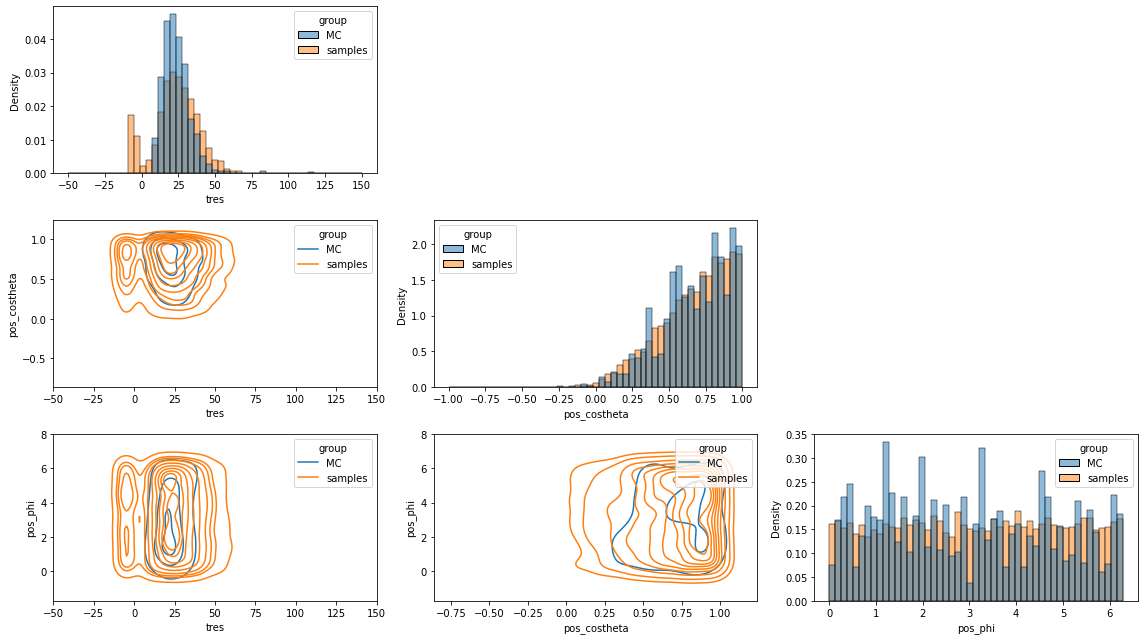

In [11]:
data_df, labels = read_photon_table_hdf_unweighted("../assets/photon_tables_extended_1.hd5", 410, ds)

data_df = data_df.loc[:5000, :]

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_theta"] = sph[:, 0]
data_df["pos_phi"] = sph[:, 1]
data_df["pos_costheta"] = np.cos(sph[:, 0])

targ, bas, lpdf_targ, lpdf_bas = pdf.to("cpu").sample(samplesize=5000, conditional_input=labels[0, :].repeat(5000, 1))
targ = pd.DataFrame(targ.numpy(), columns=["tres", "pos_theta", "pos_phi"])

data_df["group"] = "MC"
targ["group"] = "samples"
targ["weight"] = 1.
targ["pos_costheta"] = np.cos(targ["pos_theta"])

data = pd.concat([data_df, targ]).reset_index()

fig, axs = plt.subplots(3, 3, figsize=(16, 9))
bins_1 = np.linspace(-50, 150, 50)
bins_2 = np.linspace(-1, 1, 50)
bins_3 = np.linspace(0, 2*np.pi, 50)
sns.histplot(data, x="tres", weights="weight", bins=bins_1, hue="group", stat="density", ax=axs[0][0], common_norm=False)
sns.histplot(data, x="pos_costheta", weights="weight", bins=bins_2, hue="group", stat="density", ax=axs[1][1], common_norm=False)
sns.histplot(data, x="pos_phi", weights="weight", bins=bins_3, hue="group", stat="density", ax=axs[2][2], common_norm=False)
sns.kdeplot(data=data, x="tres", y="pos_costheta", weights="weight", ax=axs[1][0], hue="group", clip=[[-50, 150], [None, None]])
sns.kdeplot(data=data, x="tres", y="pos_phi", weights="weight", ax=axs[2][0], hue="group", clip=[[-50, 150], [None, None]])
sns.kdeplot(data=data, x="pos_costheta", y="pos_phi", weights="weight", ax=axs[2][1], hue="group", clip=[[-50, 150], [None, None]])


axs[0][1].set_axis_off()
axs[0][2].set_axis_off()
axs[1][2].set_axis_off()

plt.tight_layout()


In [66]:
data

,tres,pos_x,pos_y,pos_z,weight,pos_theta,pos_phi,group
0,3.904598,-0.054355,-0.076786,0.186932,0.008720,0.473119,4.096396,MC
1,7.732266,-0.066591,0.192493,0.050645,0.000283,1.327226,1.903850,MC
2,7.337506,-0.156248,0.101720,0.096641,0.001115,1.092579,2.564503,MC
3,2.542782,0.203596,0.034555,0.039415,0.000001,1.381986,0.168121,MC
4,5.134152,-0.012030,0.148058,0.148304,0.003726,0.786666,1.651868,MC
...,...,...,...,...,...,...,...,...
1361,3.615931,NaN,NaN,NaN,NaN,1.672832,6.005152,samples
1362,1159.018822,NaN,NaN,NaN,NaN,0.622218,5.687888,samples
1363,1.486053,NaN,NaN,NaN,NaN,1.541207,5.520656,samples
1364,1158.919930,NaN,NaN,NaN,NaN,0.697183,2.302784,samples


In [ ]:



fig=plt.figure(figsize=(8,6))
helper_fns.visualize_pdf(
    pdf.to("cpu"),
    fig,
    nsamples=10000,
    conditional_input=labels,
    bounds=[[-50, 150], [0, np.pi], [0, 2*np.pi]],
    #s2_norm="lambert"
    );

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_theta"] = sph[:, 0]
data_df["pos_phi"] = sph[:, 1]
corner.corner(data_df.loc[:, ["tres", "pos_theta", "pos_phi"]], range=[[-50, 150], [0, np.pi], [0, 2*np.pi]], weights=data_df["weight"]);

In [23]:

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_costheta"] = np.cos(sph[:, 0])
data_df["pos_phi"] = sph[:, 1]

sns.pairplot(data=data_df,  kind="hist", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50), np.linspace(0, np.pi, 50)))

/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


TypeError: pairplot() got an unexpected keyword argument 'weights'

/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:410: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


<AxesSubplot:xlabel='tres', ylabel='Count'>

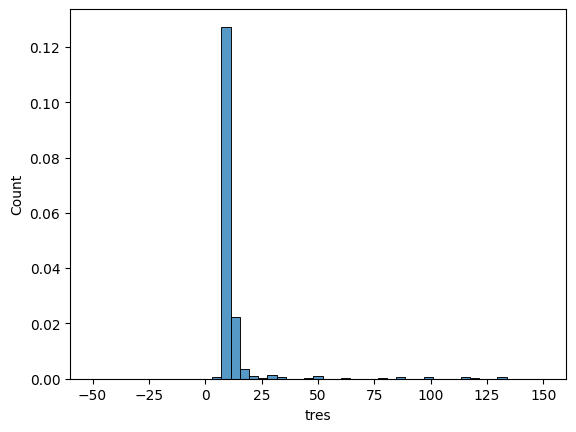

In [14]:

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_theta"] = sph[:, 0]
data_df["pos_phi"] = sph[:, 1]

sns.histplot(data=data_df, x="tres", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50)))
#sns.histplot(data=data_df, x="tres", y="pos_theta", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50), np.linspace(0, np.pi, 50)))

/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


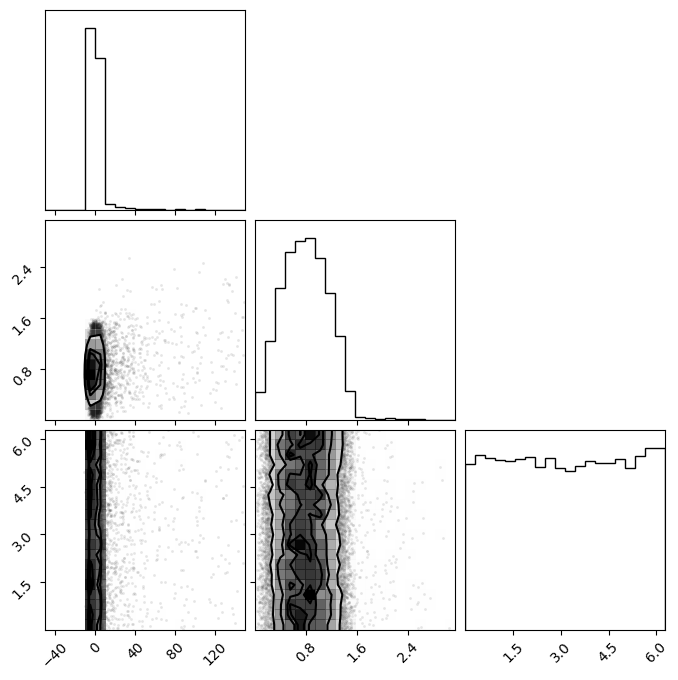

In [33]:
data_df["tres"].max()

2757.6150066785513

{'dir_costheta': 0.8359375, 'dir_phi': 5.129631754689584, 'distance': 17.518126, 'energy': 1445.9599030674115}


<AxesSubplot:>

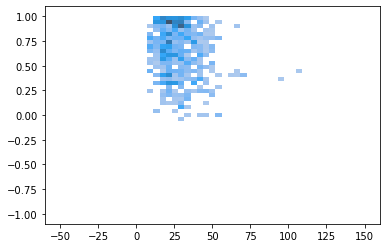

In [39]:
f = h5py.File("../assets/photon_table.hd5")
g = f["photons"]["dataset_5"]
print(dict(g.attrs))

t = g[0, :]
costheta = (g[3, :])/ 0.21
w = g[4, :] 

sns.histplot(x=t, y=costheta, weights=w, bins=(np.linspace(-50, 150, 50), np.linspace(-1, 1, 50)))



In [173]:
ds = HDF5PhotonTableUnWeighted("../assets/photon_table.hd5", 0, -1)

split_len = int(np.ceil(0.7*len(ds)))

train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=5000)


In [174]:
pdf = jammy_flows.pdf("e1", "gggg", conditional_input_dim=16+6, hidden_mlp_dims_sub_pdfs="128-128").to(device)
optim = Adam(pdf.parameters(), lr=0.001)
writer = SummaryWriter("/tmp/tensorboard/nflow")

train_iter = 0
for epoch in range(100):
    loss = 0
    for (times, labels) in train_loader:
        train_iter += 1
        optim.zero_grad()

        times = times.to(device)
        labels = labels.to(device)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels) 
        neg_log_loss = (-log_pdf).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()

        
        writer.add_scalar('Loss/train_batch', neg_log_loss.detach(), train_iter)
       
    loss /= len(train_loader)
    

    loss_test = 0
    for (times, labels) in test_loader:
        times = times.to(device)
        labels = labels.to(device)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels)
        loss_test += (-log_pdf).mean().detach()
    
    loss_test /= len(test_loader)

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/test', loss_test, epoch)
    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")



Epoch: 0  Loss Train: 7.61697  Loss Test: 0.69103
Epoch: 1  Loss Train: 0.28901  Loss Test: 0.19059
Epoch: 2  Loss Train: -0.11465  Loss Test: -0.54839
Epoch: 3  Loss Train: -0.10911  Loss Test: 0.09051
Epoch: 4  Loss Train: -0.31770  Loss Test: -0.43644
Epoch: 5  Loss Train: -0.59765  Loss Test: -1.56887
Epoch: 6  Loss Train: -0.81650  Loss Test: -1.23166
Epoch: 7  Loss Train: -0.68624  Loss Test: -0.07817
Epoch: 8  Loss Train: -0.57321  Loss Test: 0.21466
Epoch: 9  Loss Train: -0.56256  Loss Test: 1.07041
Epoch: 10  Loss Train: -0.77607  Loss Test: -1.35035
Epoch: 11  Loss Train: -1.02560  Loss Test: -0.95751
Epoch: 12  Loss Train: -0.93566  Loss Test: -1.07447
Epoch: 13  Loss Train: -1.17724  Loss Test: -1.66004
Epoch: 14  Loss Train: -1.45918  Loss Test: -1.80059
Epoch: 15  Loss Train: -1.24437  Loss Test: -0.71457
Epoch: 16  Loss Train: -1.06902  Loss Test: -1.26076
Epoch: 17  Loss Train: -1.26606  Loss Test: -1.82894
Epoch: 18  Loss Train: -1.17430  Loss Test: -1.28626
Epoch: 19 

KeyboardInterrupt: 

In [175]:
ev = read_table_hdf_unweighted("../assets/photon_table.hd5", 80)
print(ev[1])

100
{'dir_phi': 1.7590525497075664, 'dir_theta': 2.396567576390611, 'distance': 13.915788650512695, 'energy': 100000.0, 'pos_phi': 2.4195030515550093, 'pos_theta': 0.3591260640446554}


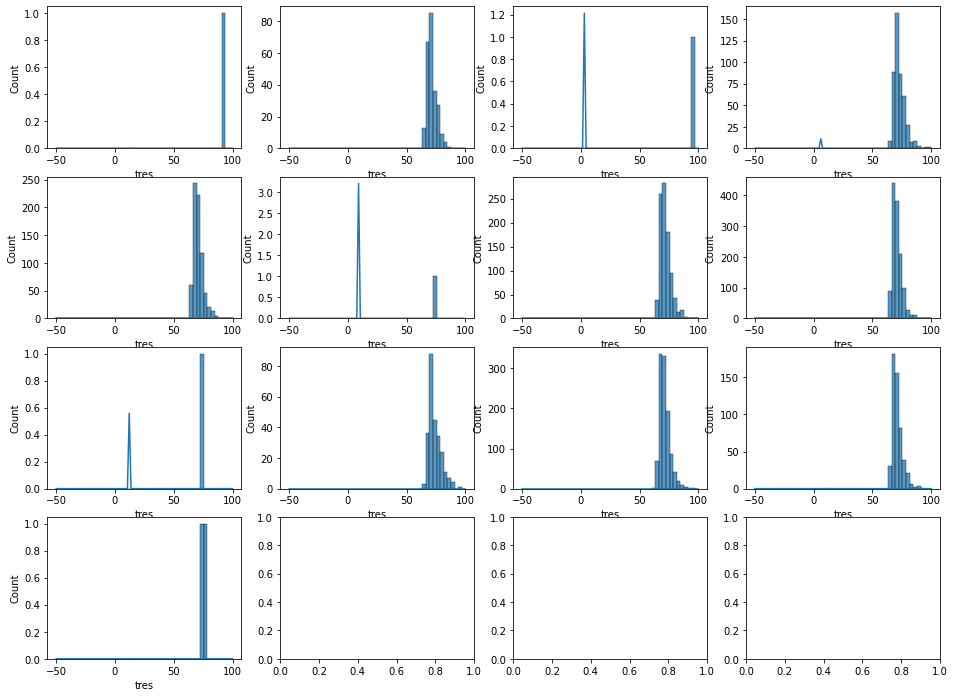

In [176]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]

for i, (grpname, grp) in enumerate(ev[0].groupby("pmt_id")):
    row, col = divmod(i, 4)
    ax = axs[row][col]
    x = grp["tres"]
    #weights = grp["weight"]
    sns.histplot(x=x, bins=np.linspace(-50, 100, 50), ax=ax)

    pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor([int(grpname) - 1]), 16)
    xs = torch.linspace(-50, 100, 100)
    labels = torch.empty((xs.shape[0], 16 + len(label_order)), dtype=torch.float64)
    labels_d = ev[1]
    for i, label in enumerate(label_order):
        labels[:, i] = labels_d[label]
    labels[:, len(label_order):] = pmt_encoding
    labels[:, 0] = np.log10(labels[:, 0])
    labels[:, 1] = np.log10(labels[:, 1])

    logpdf, _, _ = pdf(xs[:, np.newaxis].to(device), conditional_input=labels.to(device))
    ax.plot(xs, torch.exp(logpdf).detach().cpu() )
     



In [12]:
ev

(tensor([88.9582, 88.6213, 88.5577,  ..., 91.2363, 89.3823, 91.6626],
        dtype=torch.float64),
 tensor([1.8697e-05, 6.4915e-06, 1.9423e-08,  ..., 7.2944e-06, 2.3484e-05,
         2.6958e-08], dtype=torch.float64),
 tensor([[1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000]],
        dtype=torch.float64))

/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:419: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


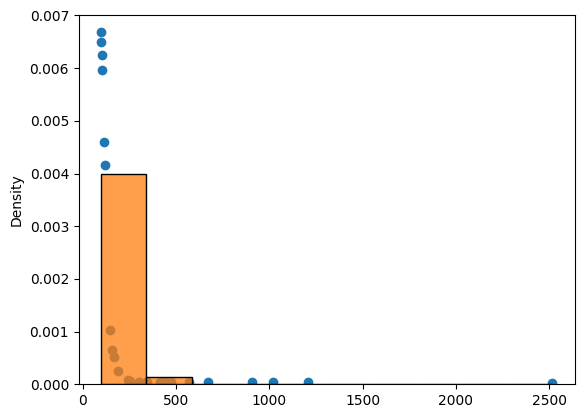

In [10]:
pdf = jammy_flows.pdf("e1", "gggg", conditional_input_dim=16+6, hidden_mlp_dims_sub_pdfs="128-128").to(device)
optim = Adam(pdf.parameters(), lr=0.001)

for epoch in range(100):
    loss = 0
    for (times, weights, labels) in train_loader:
        optim.zero_grad()

        times = times.to(device)
        labels = labels.to(device)
        weights = weights.to(device)

        weights = weights / torch.sum(weights) * len(weights)

        if any(~torch.isfinite(weights)):
            raise RuntimeError

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels) 
        neg_log_loss = (-log_pdf * weights).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()

    loss /= len(train_loader)
    

    loss_test = 0
    for (times, weights, labels) in test_loader:
        times = times.to(device)
        labels = labels.to(device)
        weights = weights.to(device)
        weights = weights / torch.sum(weights) * len(weights)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels)
        loss_test += (-log_pdf * weights).mean().detach()
    
    loss_test /= len(test_loader)

    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")



In [10]:
test_times, test_labels = next(iter(test_dataset))

logpdf, _, _ = pdf(test_times[:, np.newaxis], conditional_input=test_labels)


In [13]:
test_times

tensor([176.8423, 178.5658], device='cuda:0', dtype=torch.float64)

<AxesSubplot: >

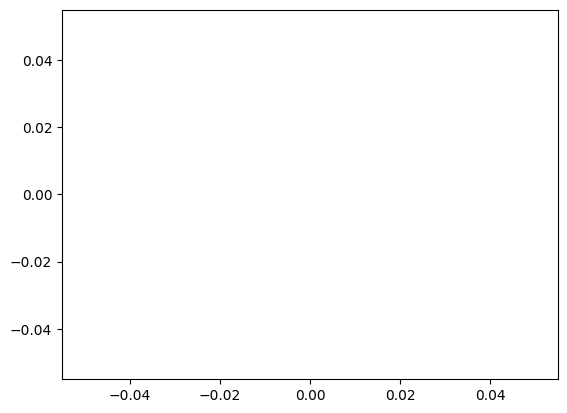

In [12]:
plt.scatter(test_times[mask].detach().cpu(), np.exp(logpdf[mask].detach().cpu()))
sns.histplot(test_times[mask].detach().cpu(), stat="density")

<AxesSubplot:ylabel='Density'>

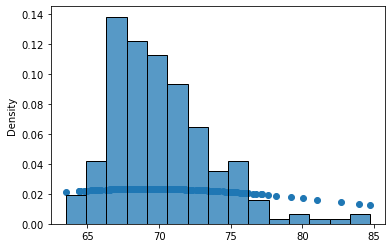

In [29]:
plt.scatter(test_per_pmt[:].detach().cpu(), np.exp(logpdf.detach().cpu()))
sns.histplot(test_per_pmt[:].detach().cpu(), stat="density")

In [34]:
labels, features = next(iter(dl))

ValueError: Shape of passed values is (2, 5126), indices imply (2, 2)

In [9]:
pdf=jammy_flows.pdf("e1", "gggg")

<KeysViewHDF5 ['dataset_1', 'dataset_10', 'dataset_11', 'dataset_12', 'dataset_2', 'dataset_3', 'dataset_4', 'dataset_5', 'dataset_6', 'dataset_7', 'dataset_8', 'dataset_9']>

In [9]:
with h5py.File("../assets/photon_table.hd5") as hdl:
    print(hdl["photon_tables/dataset_2"][:, 0])

IndexError: Index (0) out of range for empty dimension